In [18]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Nuclear masses and stellar nucleosynthesis

What do we want to do in this activity:
- Explain the LDM
- Fit the LDM to the AME2016 and check the results
- Play with LDM parameters
- Use the Saha equation to determine the S_n for the r-procees path
- Study how the changes in the r-process path with different LDM parametrixation and realistic mass models

## The Liquid Drop Model (LDM)

Strongly based on Morten Hjorth-Jensen Introduction chapter to Machine Learning and Data Analysis course (https://github.com/NuclearTalent/MachineLearningECT)

### Brief reminder on nuclear masses and binding energies

One of the most important observable of an atomic nucleus is its mass $M(Z, A)$, being $Z$ ($N$) the number of protons (neutrons) in the nucleus and $A=N+Z$ its mass number.

Atomic masses are usually tabulated in terms of the mass excess $\Delta M(N, Z)$

$$
\Delta M(N, Z) =  M(N, Z) - uA,
$$

where $u$ is the Atomic Mass Unit

$$
u = M(^{12}\mathrm{C})/12 = 931.4940954(57) \hspace{0.1cm} \mathrm{MeV}/c^2 \, .
$$

The nucleon masses are

$$
m_p =  1.00727646693(9)u \, ,
$$

and

$$
m_n = 939.56536(8)\hspace{0.1cm} \mathrm{MeV}/c^2 = 1.0086649156(6)u \, .
$$

In the [2016 mass evaluation of by W.J.Huang, G.Audi, M.Wang, F.G.Kondev, S.Naimi and X.Xu](http://nuclearmasses.org/resources_folder/Wang_2017_Chinese_Phys_C_41_030003.pdf)
there are data on masses and decays of 3437 nuclei.

The nuclear binding energy is defined as the energy required to break
up a given nucleus into its constituent parts of $N$ neutrons and $Z$
protons. In terms of the atomic masses $M(N, Z)$ the binding energy is
defined by

$$
BE(N, Z) = ZM_H c^2 + Nm_n c^2 - M(N, Z)c^2 \, ,
$$

where $\Delta_H c^2 = 7.2890$ MeV and $\Delta_n c^2 = 8.0713$ MeV.


A popular and physically intuitive model which can be used to parametrize 
the experimental binding energies as function of $A$, is the so-called 
**liquid drop model**. The ansatz is based on the following expression

$$
BE(N,Z) = a_1A-a_2A^{2/3}-a_3\frac{Z^2}{A^{1/3}}-a_4\frac{(N-Z)^2}{A} \, ,
$$

where $A$ stands for the number of nucleons and the $a_i$s are parameters which are determined by a fit 
to the experimental data.  




To arrive at the above expression we have assumed that we can make the following assumptions:

 * There is a volume term $a_1A$ proportional with the number of nucleons (the energy is also an extensive quantity). When an assembly of nucleons of the same size is packed together into the smallest volume, each interior nucleon has a certain number of other nucleons in contact with it. This contribution is proportional to the volume.

 * There is a surface energy term $a_2A^{2/3}$. The assumption here is that a nucleon at the surface of a nucleus interacts with fewer other nucleons than one in the interior of the nucleus and hence its binding energy is less. This surface energy term takes that into account and is therefore negative and is proportional to the surface area.

 * There is a Coulomb energy term $a_3\frac{Z^2}{A^{1/3}}$. The electric repulsion between each pair of protons in a nucleus yields less binding. 

 * There is an asymmetry term $a_4\frac{(N-Z)^2}{A}$. This term is associated with the Pauli exclusion principle and reflects the fact that the proton-neutron interaction is more attractive on the average than the neutron-neutron and proton-proton interactions.

### The AME 2016 data

Let us start with reading and organizing our data for the experimental masses and binding energies collected in the AME 2016 database and see how the masses look like as a function of the mass number $A$

,N,Z,A,Element,Ebinding/A,Ebinding
0,0,1,1,H,0.000000,0.000000
1,1,1,2,H,1.112283,2.224566
2,2,1,3,H,2.827265,8.481795
3,1,2,3,He,2.572680,7.718040
5,3,1,4,H,1.720449,6.881796
...,...,...,...,...,...,...
3304,156,108,264,Hs,7.298375,1926.771000
3310,157,108,265,Hs,7.296247,1933.505455
3317,158,108,266,Hs,7.298273,1941.340618
3338,159,110,269,Ds,7.250154,1950.291426


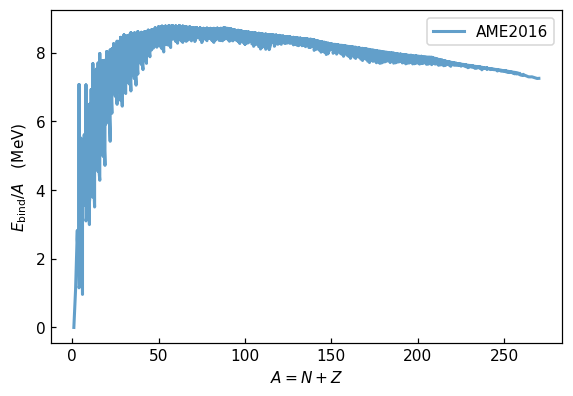

In [19]:
%reset -f
# 
# Import relevant libraries
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#
# Where to save the figures and data files
#
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/Plots"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

#
# File containing experimental masses
#
infile = open(data_path("MassEval2016.dat"),'r')


#
# Read the experimental data with Pandas
#
Masses = pd.read_fwf(infile, usecols=(2,3,4,6,11),
              names=('N', 'Z', 'A', 'Element', 'Ebinding/A'),
              widths=(1,3,5,5,5,1,3,4,1,13,11,11,9,1,2,11,9,1,3,1,12,11,1),
              header=39,
              index_col=False)

# Extrapolated values are indicated by '#' in place of the decimal place, so
# the Ebinding column won't be numeric. Coerce to float and drop these entries.
Masses['Ebinding/A'] = pd.to_numeric(Masses['Ebinding/A'], errors='coerce')
Masses = Masses.dropna()

# Convert from keV to MeV, and from energy per nucleon to energy
Masses['Ebinding/A'] /= 1000
Masses['Ebinding'] = Masses['Ebinding/A'] * Masses['A']
display(Masses)


#
# Let's plot the experimental binding energies per nucleon
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'$A = N + Z$')
ax.set_ylabel(r'$E_\mathrm{bind}/A \quad (\mathrm{MeV})$')
ax.plot(Masses['A'], Masses['Ebinding/A'], alpha=0.7, lw=2,
            label='AME2016')
ax.legend()
save_fig("Masses AME2016")
plt.show()

As you can see, the binding energies (per nucleon) saturates at $A \sim 62$, in corrispondence of the iron-nickel group in the periodic table.

<font color=red>
    
###  Questionnaire
    
 - Knowing that elements lighther than iron are created in stellar environments through fusion reactions, which implications does have the saturation of the binding energy in the nucleosynthesis of elements heavier than iron? 
</font>

### LDM vs AME2016 experimental data

We can now use the experimental binding energies to fit the parameters of the liquid drop model. We will do it by using the scikit package

Root-mean-square error: 3.73 MeV
Mean absolute error: 2.65 MeV
LDM coefficients (MeV): a_vo = 15.1904; a_su = -15.7942; a_co = -0.6807; a_sy = -22.1924 




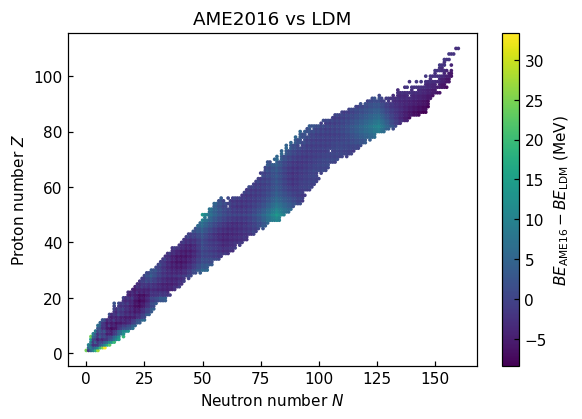

In [43]:
Masses_f = Masses.copy()

A = Masses_f['A']
Z = Masses_f['Z']
N = Masses_f['N']
Element = Masses_f['Element']
Energies = Masses_f['Ebinding']

#
# Now we set up the design matrix X used in our fitting procedure
#
X = np.zeros((len(A),5))
X[:,0] = 1
X[:,1] = A
X[:,2] = A**(2.0/3.0)
X[:,3] = Z**2*A**(-1.0/3.0)
X[:,4] = (N-Z)**2*A**(-1.0)

#
# Fit
#
lrg = skl.LinearRegression()
clf = lrg.fit(X, Energies) # or clf = skl.LinearRegression().fit(X, Energies)
fity = lrg.predict(X)

#
# Statistics
#
# The mean squared error                               
print("Root-mean-square error: %.2f MeV" % np.sqrt(mean_squared_error(Energies, fity)))
# Mean absolute error                                                           
print('Mean absolute error: %.2f MeV' % mean_absolute_error(Energies, fity))
# LDM coefficients
print('LDM coefficients (MeV): a_vo = %.4f; a_su = %.4f; a_co = %.4f; a_sy = %.4f \n\n' %\
      (clf.coef_[1], clf.coef_[2], clf.coef_[3], clf.coef_[4]))

#
# Let's insert the result in the masses dataframe
#
Masses_f['Eapprox']  = fity
Masses_f['Residuals'] = Masses_f['Ebinding'] - Masses_f['Eapprox']
#display(Masses_f)

#
# Generate a plot comparing the experimental with the fitted values values
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.title('AME2016 vs LDM')
plt.scatter(Masses_f['N'], Masses_f['Z'], s=2, marker='o', c=Masses_f['Residuals'])
plt.colorbar(label=r'$BE_\mathrm{AME16} - BE_\mathrm{LDM}$ (MeV)')
save_fig("AME2016vsLDM")
plt.show()

<font color=red>
    
###  Questionnaire
    
 - Given the plot of the binding energy differences between the AME2016 experimental data and the liquid-drop-model, could you identify which type of nuclei are worstly described by the model? 

 - How does this relate with the quantum many-body nature of the nucleus? Which conclusions can be drawned regarding the liquid drop model (i.e., which physics is majorly missing in this model)?
    
</font>

### Separation energies

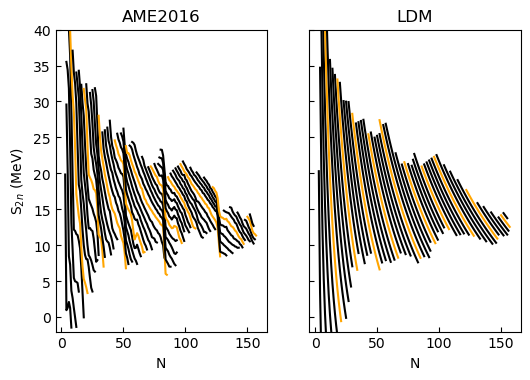

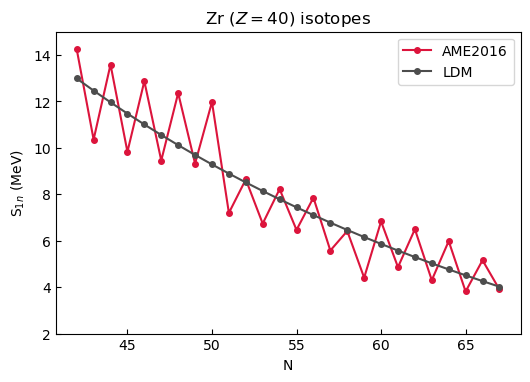

In [22]:
#
# Let's write a fucntion to compute the neutron separation energies
#
def get_Sn(masses_df):
    """
    Function to compute neutron separation energies in masses_df 
    """
    # Sort dataframe as a function of Z and A
    masses_df.sort_values(['Z', 'A'], inplace=True)

    # Get neutron and proton separation energies
    masses_df['S1n'] = masses_df['Ebinding'].diff(1)
    masses_df['S2n'] = masses_df['Ebinding'].diff(2)
    masses_df['S1n_app'] = masses_df['Eapprox'].diff(1)
    masses_df['S2n_app'] = masses_df['Eapprox'].diff(2)

    # Remove separation energies from transitional nuclei
    cond_s1n = (masses_df['Z'].diff(1) != 0) | (masses_df['N'].diff(1) != 1)
    cond_s2n = (masses_df['Z'].diff(2) != 0) | (masses_df['N'].diff(2) != 2)
    masses_df.loc[cond_s1n, 'S1n'] = float('NaN')
    masses_df.loc[cond_s2n, 'S2n'] = float('NaN')
    masses_df.loc[cond_s1n, 'S1n_app'] = float('NaN')
    masses_df.loc[cond_s2n, 'S2n_app'] = float('NaN')
    
    return masses_df

#
# Compute S1n and S2n
#
Masses_f = get_Sn(Masses_f)

#
# Let's plot the 2-neutron separation energies from AME and LDM
#
fig, axv = plt.subplots(1, 2, sharex=True, sharey=True, dpi=100)
for i in Masses_f['Z'].unique():
    masses_iso = Masses_f.loc[Masses_f['Z'] == i]
    if i%10 == 0:
        color = 'orange'
    else:
        color = 'k'
    if i%2 == 0:
        axv[0].plot(masses_iso['N'], masses_iso['S2n'], '-', c=color)
        axv[1].plot(masses_iso['N'], masses_iso['S2n_app'], '-', c=color)

plt.ylim(-2, 40)
axv[0].set_xlabel('N')
axv[1].set_xlabel('N')
axv[0].set_ylabel('S$_{2n}$ (MeV)')
axv[0].set_title('AME2016')
axv[1].set_title('LDM')
plt.show()


#
# Let's plot the 2-neutron separation energies from AME and LDM
#
fig = plt.figure(dpi=100)
for i in Masses_f['Z'].unique():
    masses_iso = Masses_f.loc[Masses_f['Z'] == i]
    if i == 40:
        plt.plot(masses_iso['N'], masses_iso['S1n'], '-o', c='crimson', ms=4, label='AME2016')
        plt.plot(masses_iso['N'], masses_iso['S1n_app'], '-o', c='0.3', ms=4, label='LDM')

plt.ylim(2, 15)
plt.xlabel('N')
plt.ylabel('S$_{1n}$ (MeV)')
plt.title('Zr ($Z=40$) isotopes')
plt.legend()
plt.show()

<font color=red>
    
###  Questionnaire
    
 - Looking at the plot of the two-neutron separation energies as a function of neutron number $N$, could you asses what is the impact of shell closure in this observable? 

 - Given the plot of the one-neutron separation energy of Zirconium isotopes, which experimental feature is missing in the liquid drop model? Relate this with the tendency of protons pairs and neutrons pairs to occur. Can you guess a modification of the liquid drop-model which will take account of this effect? 
</font>


## The r-process path

Notes taken from Arcones and Martinez Pinedo Phys.Rev. C83 045809 (2011)

### Network Calculations

The nucleosynthesis occuring in stellar environments can be simulated by large-scale nuclear network calculations. The general goal of such calculations is to study the temporal evolution of nuclear abundances $Y_i = n_i / n$, being $n_i$ the number density of species $i$ and $n \approx \rho / m_u$ the total number density of nucleons present in the environment. In this activity, we will explore the impact of nuclear masses in a specific nucleosynthesis process, the rapid-neutron capture process (or r-process).

In a simplified (yet realistic) description of the r-process, we can neglect charged particle reactions,
fission and alpha decays and assume that the evolution of the
nuclear abundances is determined only by three types of reactions:
 - Neutron captures $(n, \gamma)$: $^{A}Z + n \to ^{A+1}Z$.
 - Photodissociation $(\gamma, n)$: $^{A+1}Z + \gamma \to ^{A}Z + n$
 - Beta-decays: $ ^AZ \to ^A(Z+1)$.

Given such simplification, the change of the abundance of a nucleus with charge
$Z$ and mass number $A$ is given by the following differential equation:

\begin{eqnarray}
  \frac{d Y(Z,A)}{dt} & = & Y(Z, A)\bigr\rvert_\textrm{creation} - Y(Z, A)\bigr\rvert_\textrm{destruction} \nonumber \\
  & = &  \lambda_{(n,\gamma)}(Z, A-1) Y(Z,A-1) + 
  \lambda_{(\gamma, n)}(Z,A+1) Y(Z,A+1) + 
  \lambda_{\beta}(Z-1,A) Y(Z-1,A) \nonumber \\
  & - &  \left(\lambda_{(n,\gamma)}(Z, A)  +
    \lambda_{\gamma} (Z,A) + \lambda_{\beta}(Z, A)\right) Y(Z,A)
      \label{eq:yza} \tag{1}
\end{eqnarray}
where $\lambda_{i}(Z,A)$ is the reaction rate for a nucleus $^AZ$ and a reaction $i=\{(n,\gamma); (\gamma, i); \beta\}$. 

The neutron capture rate $\lambda_{(n,\gamma)}$ is usually expressed as a function of the neutron abundance $Y_n$, the distribution averaged cross section 
$\langle \sigma v\rangle_{Z,A}$ and the baryon density $\rho$ as

\begin{equation*} 
    \lambda_{(n,\gamma)}(Z,A) = \rho N_A Y_n \langle \sigma v\rangle_{Z,A} \,,
\end{equation*}
and the photodissociation rate is related to the neutron capture rate by
detailed balance:

\begin{equation}
  \lambda_\gamma(Z,A+1) =  \langle\sigma v\rangle_{Z,A}
  \left(\frac{m_u k T}{2\pi\hbar^2}\right)^{3/2} \frac{2
    G(Z,A)}{G(Z,A+1)}\left(\frac{A}{A+1}\right)^{3/2}
  \exp \left[-\frac{S_n(Z,A+1)}{kT}\right],
  \label{eq:photonv} \tag{2}
\end{equation}
where $G$ is the partition function (which measures the internal degrees of freedom of the nucleus) and 
$S_n = m_n + M(Z,A-1)-M(Z,A)$ is the neutron separation energy with $m_n$ the
neutron mass and $M(Z,A)$ the mass of the nucleus.

Similarly to what we have done in Eq. (\ref{eq:yza}), we can write an expression for the evolution of neutron abundances:

\begin{equation}
  \frac{dY_n}{dt} = 
  - \sum_{Z,A} \rho N_A \langle \sigma v \rangle_{Z,A} Y_n Y(Z,A) 
  + \sum_{Z,A} \lambda_{\gamma} (Z,A) Y(Z,A)
  \label{eq:dyn} \tag{3}
\end{equation}

The system of differential equations defined by
Eq. \eqref{eq:yza} and \eqref{eq:dyn} allows for several
approximations that are valid in different physical regimes. A
commonly used assumption in classical r-process calculations is the
$(n,\gamma)\rightleftarrows(\gamma,n)$ equilibrium. This approximation
is valid whenever the neutron density ($N_n = \rho N_A Y_n \gtrsim
10^{20}$ cm$^{-3}$) and temperature ($T\gtrsim
1$ GK) are large enough to warrant
that both the rate of neutron capture ($\lambda_{n, \gamma}$)
and the photodissociation rate ($\lambda_{\gamma, n}$) are much larger than
the beta decay rate ($\lambda_\beta$) for all the nuclei participating
in the network. Under this conditions the evolution of the system is
mainly determined by the beta decay rates as the abundances along an
isotopic chain are inmediatly adjusted to an equilibrium between
neutron captures and photodissociations, i.e.

\begin{equation}
    N_n Y(Z,A)
    \langle\sigma v\rangle_{Z,A} = \lambda_\gamma(Z,A+1)
    Y(Z,A+1)
   \label{eq:ngeq} \tag{4}
\end{equation}

Combining this result with Eq. \eqref{eq:photonv} one
obtains that the abundances in an isotopic chain are given by the
simple relation:

\begin{equation}
  \frac{Y(Z,A+1)}{Y(Z,A)} = N_n\left(\frac{2\pi\hbar^2}{m_ukT}\right)^{3/2}
  \left(\frac{A+1}{A}\right)^{3/2}\frac{G(Z,A+1)}{2G(Z,A)}
  \exp\left[\frac{S_n(Z,A+1)}{kT}\right].
  \label{eq:yequiv} \tag{5}
\end{equation}
For each isotopic chain, the above equation defines a nucleus that has
the maximum abundance and which is normally known as waiting point
nucleus as the flow of neutron captures "waits" for this nucleus to
beta-decay. The set of waiting point nuclei constitutes the r-process
path. The maximum of the abundance distribution can be determined
setting the left-hand side of Eq. (\ref{eq:yequiv}) to 1, which
results in a value of $S_n$ that is the same for all isotopic chains
for a given neutron density and temperature:

\begin{equation}
  S^0_n (\text{MeV}) = \frac{T_9}{5.04} \left(34.075 - \log N_n +
    \frac{3}{2} \log T_9 \right),    
  \label{eq:sneq} \tag{6}
\end{equation}
where $T_9$ is the temperature in units of $10^9$ K and $N_n$ is the
neutron density in cm$^{-3}$. Equation (\ref{eq:sneq}) implies that
the r-process proceeds along lines of constant neutron separation
energies towards heavy nuclei. For typical r-process conditions this
corresponds to $S^0_n \sim $2--3 MeV. Due to pairing, the most
abundance isotopes have always an even neutron number. For this
reason, it may be more appropriate to characterize the most abundance
isotope in an isotopic chain as having a two-neutron separation energy
$S_{2n} = 2 S^0_n$. The two-neutron
separation energy is not a continuous function of neutron number but
shows large jumps particularly close to magic neutron numbers. For
this reason r-process nuclei near to magic numbers have neutron
separation energies much larger than the typical 2--3 MeV and the
r-process path moves closer to the stability.

### Nuclear masses and r-process path

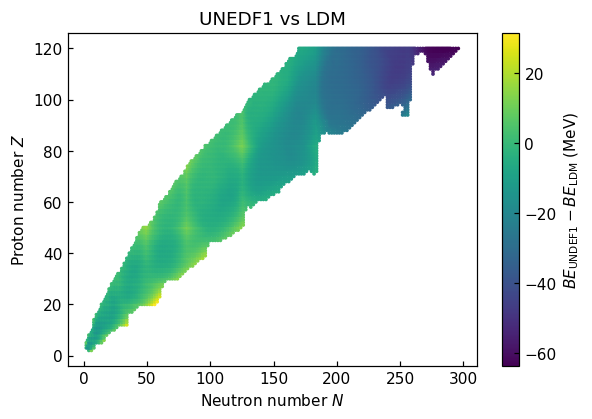

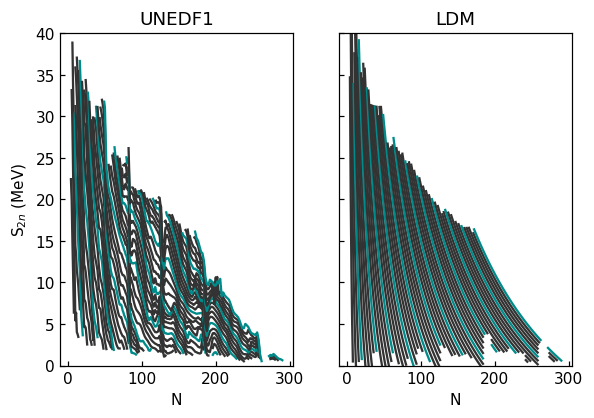

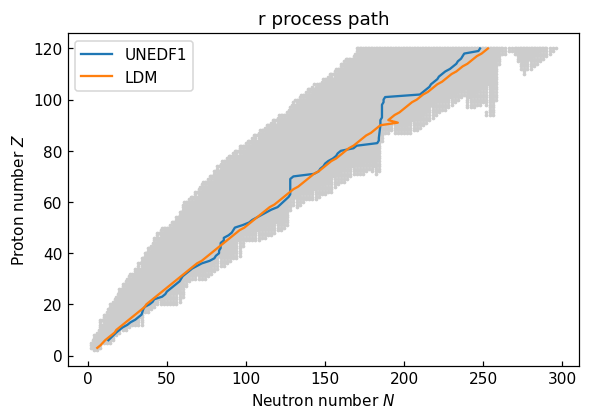

In [25]:
#
# File containing theoretical masses
#
infileth = open(data_path("UNEDF1_masses.dat"),'r')

#
# Read the theoretical data with Pandas
#
Masses_th = pd.read_csv(infileth, usecols=(1,2,3,0,4),
              names=('Element', 'Z', 'N', 'A', 'Ebinding'),
              header=1, delim_whitespace=True,
              index_col=False)

Masses_th['Ebinding'] *= -1.0

#
# Let's make a copy of the theoretical dataframe and use it to compute our LDM
#
Masses_y = Masses_th.copy()

A = Masses_y['A']
Z = Masses_y['Z']
N = Masses_y['N']

#
# Set your LDM parameters
#
a_vo = clf.coef_[1]
a_su = clf.coef_[2]
a_co = clf.coef_[3]
a_sy = clf.coef_[4]

#
# Compute LDM binding energies and residuals 
#
Masses_y['Eapprox'] = a_vo*A + a_su*A**(2./3.) + a_co*Z**2*A**(-1.0/3.0) + a_sy*(N-Z)**2/A  
Masses_y['Residuals'] = Masses_y['Ebinding'] - Masses_y['Eapprox']

#
# Compute S1n and S2n
#
Masses_y = get_Sn(Masses_y)
#display(Masses_y)

#
# Generate a plot comparing the experimental with the fitted values
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.title('UNEDF1 vs LDM')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=2, marker='o', c=Masses_y['Residuals'])
plt.colorbar(label=r'$BE_\mathrm{UNDEF1} - BE_\mathrm{LDM}$ (MeV)')
save_fig("AME2016vsyourLDM")
plt.show()

#
# Statistics
#
# The mean squared error                               
#print("Root-mean-square error: %.2f MeV" % np.sqrt(mean_squared_error(Masses_y['Ebinding'], Masses_y['Eapprox'])))
# Mean absolute error                                                           
#print('Mean absolute error: %.2f MeV' % mean_absolute_error(Masses_y['Ebinding'], Masses_y['Eapprox']))

def find_wp(masses_df, s2n):
    """
    Let's define a function to find the waiting points in a given mass table
    """
    wp = masses_df[masses_df[s2n] <= 4][['Z', 'N', s2n]]
    wp = wp.groupby('Z')
    wp = wp.apply(lambda t: t[t['N']==t['N'].min()])
    return wp

unedf_wp = find_wp(Masses_y, 'S2n')
ldm_wp = find_wp(Masses_y, 'S2n_app')


#
# Plot the 2-neutron separation energies from AME and your LDM
#
fig, axv = plt.subplots(1, 2, sharex=True, sharey=True, dpi=110)
for i in Masses_y['Z'].unique():
    masses_iso = Masses_y.loc[Masses_y['Z'] == i]
    if i%10 == 0:
        color = 'darkcyan'
    else:
        color = '0.2'
    if i%2 == 0:
        axv[0].plot(masses_iso['N'], masses_iso['S2n'], '-', c=color)
        axv[1].plot(masses_iso['N'], masses_iso['S2n_app'], '-', c=color)

#axv[0].plot(unedf_wp['N'], unedf_wp['S2n'], 'o', ms=1, c='orange')
#axv[1].plot(ldm_wp['N'], ldm_wp['S2n_app'], 'o', ms=1, c='orange')

plt.ylim(0, 40)
axv[0].set_xlabel('N')
axv[1].set_xlabel('N')
axv[0].set_ylabel('S$_{2n}$ (MeV)')
axv[0].set_title('UNEDF1')
axv[1].set_title('LDM')
plt.show()


#
# Generate a plot comparing the r-process paths obtained in the two models
#
fig, ax = plt.subplots(dpi=110)
ax.set_xlabel(r'Neutron number $N$')
ax.set_ylabel(r'Proton number $Z$')
plt.title('r process path')
plt.scatter(Masses_y['N'], Masses_y['Z'], s=2, marker='o', c='0.8')
plt.plot(unedf_wp['N'], unedf_wp['Z'], label='UNEDF1')
plt.plot(ldm_wp['N'], ldm_wp['Z'], label='LDM')
plt.legend()
save_fig("rppath")
plt.show()